In [16]:
import numpy as np
from scipy import sparse
import pylab as plt
from sklearn import datasets
from scipy.optimize import linprog

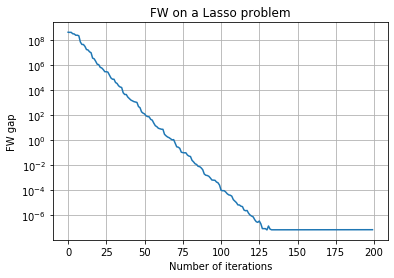

Sparsity of solution: 0.13%


In [110]:
'''from Fabian Pedregosa'''
def FW(alpha, max_iter=200, tol=1e-8):
    # .. initial estimate, could be any feasible point ..
    x_t = sparse.dok_matrix((n_features, 1))
    trace = []  # to keep track of the gap

    # .. some quantities can be precomputed ..
    Atb = A.T.dot(b)
    for it in range(max_iter):
        # .. compute gradient. Slightly more involved than usual because ..
        # .. of the use of sparse matrices ..
        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)
        # .. the LMO results in a vector that is zero everywhere except for ..
        # .. a single index. Of this vector we only store its index and magnitude ..
        idx_oracle = np.argmax(np.abs(grad))
        mag_oracle = alpha * np.sign(-grad[idx_oracle])
        g_t = x_t.T.dot(grad).ravel() - grad[idx_oracle] * mag_oracle
        trace.append(g_t)
        if g_t <= tol:
            break
        q_t = A[:, idx_oracle] * mag_oracle - Ax
        step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        x_t = (1. - step_size) * x_t
        x_t[idx_oracle] = x_t[idx_oracle] + step_size * mag_oracle
    return x_t, np.array(trace)

n_samples, n_features = 1000, 10000
A, b = datasets.make_regression(n_samples, n_features)
# .. plot evolution of FW gap ..
sol, trace = FW(.5 * n_features)
plt.plot(trace)
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('FW gap')
plt.title('FW on a Lasso problem')
plt.grid()
plt.show()

sparsity = np.mean(sol.toarray().ravel() != 0)
print('Sparsity of solution: %s%%' % (sparsity * 100))

In [129]:
'''frank wolfe functions'''
def gradient(F, x):
    return None

def linear_program_oracle(coef, A, b, bounds):
    '''
    f(x) = c^Tx
    Ax <= b
    x within bounds 
    coef = [c_x0, c_x1, ....] coefficient of the equation
    A = [[a0_x0, a0_x1, ...],[a1_x0, a1_x1, ...]] constraint matrix
    b = [b0, b1, ....] constraint vector
    bounds = [(lb_x0, ub_x0), (lb_x1, ub_x1),....]
    '''
    res = linprog(coef, A_ub=A, b_ub=b, bounds=bounds)
    return res["x"] 

def frank_wolfe(F, x, max_iter=200, alpha=0.1, tol=1e-8):
    for k in range(max_iter):
        grad = gradient()
        x_hat = linear_program_oracle()
        x = x + alpa*(x_hat - x)
    return x

In [132]:
'''Linear Programming'''
# f(x0,x1) = -x0 + 4x1
c = [-1, 4]
#A = [[-3, 1], [1, 2]]
#b = [6, 4]

A = [[-3, 1], [1, 2]]
b = [6, 4]

x0_bounds = (None, None)
x1_bounds = (-3, None)
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds])
print(res)

print(linear_program_oracle(c, A, b, [(None, None), (-3, None)]))

     con: array([], dtype=float64)
     fun: -22.0
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([3.90000000e+01, 1.77635684e-15])
  status: 0
 success: True
       x: array([10., -3.])
[10. -3.]


In [118]:
# gradient test
'''
f = lambda x: x[0]**2 + x[1]**2
c = 1e-10
x = np.array([1,2])
'''
f = lambda x: x[0]**4 - 32*x[0] + x[1]**2 - 8*x[1]
c = 1e-10
x = np.array([2,4]) #x = (2,4) is the global minimum, hence gradient = 0


def grad_KWSA(F, x, c, d):
    grad = 0
    e = np.zeros(d)
    for i in range(d):
        e[i] = 1 #cb-vector
        grad += ((F(x + c*e) - F(x))/c)*e #calculate the gradient
        e[i] = 0 #reset cb-vector
    return grad

def grad_RDSA(F, x, c, d):
    z = np.random.normal(0, 1, size=(d)) #mean = 0, std = 1
    grad = ((F(x + c*z) - F(x))/c)*z
    return grad

def grad_IRDSA(F, x, c, d, m=5):
    grad = 0
    for i in range(m):
        z = np.random.normal(0, 1, size=(d)) #mean = 0, std = 1
        grad += ((F(x + c*z) - F(x))/c)*z
    return grad/m

print("KWSA", grad_KWSA(f, x, c, len(x)))
print("RDSA", grad_RDSA(f, x, c, len(x)))
print("IRDSA", grad_IRDSA(f, x, c, len(x)))

KWSA [0. 0.]
RDSA [-0. -0.]
IRDSA [0. 0.]


In [158]:
'''Zeroth Order Frank Wolfe [Sahu et al]'''
'''Stochastic Gradient Free Frank Wolfe - Convex'''
def SGF_frank_wolfe_cvx(F, x, LPO_var, max_iter=200, m=100, mode="KWSA"):
    '''
    F = f(x)
    x = input vector or init starting point
    LPO_var = {A, b, bounds}, the constraints and bounds
    '''
    A = LPO_var["A"]; b = LPO_var["b"]; bounds = LPO_var["bounds"]
    dim = len(x)
    t = np.arange(max_iter) # sequence of t = 0,1,....max_iter
    gamma = 2/(t + 8) # initialize gamma sequences
    # rho and c sequences:
    rho = c = None
    if mode == "KWSA":
        rho = 4/((t+8)**(2/3))
        c = 2/((dim**(1/2)) * ((t + 8)**(1/3)))
    elif mode == "IRDSA":
        rho = 4/(((1 + (dim/m))**(1/3)) * ((t+8)**(2/3)))
        c = 2*np.sqrt(m)/(dim**(3/2) * (t+8)**(1/3))
    elif mode == "RDSA":
        rho = 4/(dim**(1/3) * (t+8)**(2/3))
        c = 2/(dim**(3/2) * (t+8)**(1/3))
    d = np.zeros(dim) #initial value d_0 = 0
    for i in t: #loop
        grad = 0 #placeholder
        if mode == "KWSA":
            grad = grad_KWSA(F, x, c[i], dim)
        elif mode == "IRDSA":
            grad = grad_IRDSA(F, x, c[i], dim)
        elif mode == "RDSA":
            grad = grad_RDSA(F, x, c[i], dim)
        d = (1-rho[i])*d + rho[i]*grad #used for linear programming oracle (LPO)
        v = linear_program_oracle(d, A, b, bounds) ### LPO
        x = (1-gamma[i])*x + gamma[i]*v
        print(x)
    return x

In [161]:
'''
function from: http://www.math.udel.edu/~angell/Opt/FW.pdf
(1,695, 1,914) is the optimal value
'''
f = lambda x: x[0]**4 - 32*x[0] + x[1]**2 - 8*x[1]
x = np.array([1, 0]) #x = (2,4) is the global minimum, hence gradient = 0
A = [[1, -1], [3, 1]]
b = [1, 7]
bounds = [(0, None), (0, None)]
LPO_var = {"A":A, "b":b, "bounds":bounds}
SGF_frank_wolfe_cvx(f, x, LPO_var, max_iter=500, mode = "IRDSA")

[0.75 0.  ]
[0.58333333 1.55555556]
[0.46666667 2.64444444]
[0.38181818 3.43636364]
[0.31818182 4.03030303]
[0.57692308 3.56410256]
[0.78021978 3.1978022 ]
[0.67619048 3.7047619 ]
[0.84166667 3.36666667]
[0.97794118 3.08823529]
[1.09150327 2.85620915]
[1.1871345  2.66081871]
[1.26842105 2.49473684]
[1.14761905 2.92380952]
[1.22510823 2.74891775]
[1.11857708 2.50988142]
[1.02536232 2.88405797]
[0.94333333 2.65333333]
[0.87076923 2.98769231]
[0.95441595 2.84045584]
[1.02910053 2.70899471]
[1.09605911 2.591133  ]
[1.15632184 2.48505747]
[1.21075269 2.38924731]
[1.26008065 2.30241935]
[1.30492424 2.22348485]
[1.34581105 2.15151515]
[1.26890756 2.42857143]
[1.1984127  2.68253968]
[1.13363363 2.91591592]
[1.07396871 3.13086771]
[1.12145749 3.02159244]
[1.06538462 2.87051282]
[1.06219512 2.7304878 ]
[1.05923345 2.60046458]
[1.10299003 2.52602436]
[1.14376321 2.45665962]
[1.18181818 2.39191919]
[1.2173913  2.33140097]
[1.16558742 2.53006475]
[1.11702128 2.71631206]
[1.15306122 2.6462585 ]
[1.1

[1.19751976 3.11450235]
[1.20157269 3.10382304]
[1.20559499 3.09322444]
[1.20958698 3.08270572]
[1.21354895 3.07226609]
[1.2174812  3.06190476]
[1.22138404 3.05162095]
[1.22525775 3.04141388]
[1.22910263 3.03128279]
[1.23291895 3.02122694]
[1.236707   3.01124557]
[1.24046707 3.00133796]
[1.24419942 2.99150337]
[1.24790432 2.9817411 ]
[1.25158205 2.97205043]
[1.25523287 2.96243068]
[1.25885704 2.95288113]
[1.26245482 2.94340113]
[1.26602647 2.93398999]
[1.26957224 2.92464704]
[1.27309237 2.91537163]
[1.27658712 2.90616311]
[1.28005672 2.89702084]
[1.28350143 2.88794419]
[1.28692147 2.87893252]
[1.29031708 2.86998523]
[1.2936885  2.86110169]
[1.29703594 2.8522813 ]
[1.30035965 2.84352347]
[1.29422588 2.86312949]
[1.29754717 2.85436182]
[1.30084507 2.8456559 ]
[1.3041198  2.83701114]
[1.30737158 2.82842697]
[1.31060061 2.81990284]
[1.31380712 2.81143817]
[1.31699131 2.80303243]
[1.32015339 2.79468506]
[1.32329356 2.78639552]
[1.32641202 2.77816328]
[1.32950898 2.76998782]
[1.33258463 2.76

array([1.35987869, 2.74265422])